## Grupo 7: Rubén Gómez y Adrián Sanjuán

# Índice
- [Carga de datos](#cargadedatos)
- [Modelo](#modelo)
  - [Creación del modelo](#creacion)
  - [Elección de parámetros](#eleccion)
  - [Regularización](#reg)
  - [Métricas](#metricas)
  - [Evaluación del modelo](#eval)  
- [Conclusión](#conclusion)
- [Bibliografía](#bib)

In [ ]:
import numpy as np
from pandas.io.parsers import read_csv
import pandas as pd
import matplotlib.pyplot as plt
import math
from sklearn.datasets import make_blobs
from scipy import integrate
from sklearn.preprocessing import PolynomialFeatures
from numpy import arange, meshgrid, sqrt
from google.colab import drive
from sklearn.model_selection import train_test_split
drive.mount('/content/drive')
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

from sklearn.preprocessing import OneHotEncoder
import seaborn as sns
import time
import itertools
from sklearn.metrics import confusion_matrix

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<a name="cargadedatos"></a>
# Carga de datos

In [ ]:
train = read_csv('/content/drive/MyDrive/AA/PFinal/train.csv', index_col= 0)
test = read_csv('/content/drive/MyDrive/AA/PFinal/test.csv', index_col= 0)
valid = read_csv('/content/drive/MyDrive/AA/PFinal/valid.csv',index_col= 0)

In [ ]:
# Código para experimentar con variables reducidas y undersampling

'''train = train[['previous_year_rating','awards_won','avg_training_score','is_promoted']]
valid = valid[['previous_year_rating','awards_won','avg_training_score','is_promoted']]
test = test[['previous_year_rating','awards_won','avg_training_score','is_promoted']]
train['is_promoted'].value_counts()
df_0 = train[train['is_promoted'] == 0].sample(n=2443, random_state=10)
df_1 = train[train['is_promoted'] == 1]
train = pd.concat([df_0,df_1])
train['is_promoted'].value_counts()'''

In [ ]:
X_train = train.drop(['is_promoted'], axis=1).values
y_train = train['is_promoted'].values
X_valid = valid.drop(['is_promoted'], axis=1).values
y_valid = valid['is_promoted'].values
X_test = test.drop(['is_promoted'], axis=1).values
y_test = test['is_promoted'].values



En el código comentado anteriormente se ofrece el código que se ha utilizado para experimentar con menos variables (las tres más correlacionadas) y/o haciendo undersampling para igualar el número de instancias de entrenamiento de cada clase. Estos experimentos solo se han realizado para la regresión, por un lado es el modelo que más afectado se ve por la dimensionalidad (para valores altos de la transformación polinomial el tiempo de ejecución es muy elevado), y por otro lado es el único para el que no existía un parámetro para dar más importancia a una clase que a otra (ya que está programado por nosotros sin tener en cuenta esta opción). A la vista de los resultados se ha decidido tener en cuenta las 20 variables y todas las instancias.

<a name="modelo"></a>
#Modelo
<a name="creacion"></a>
## Creación del modelo

En este caso la creación del modelo consiste en aplicar una transformación polinomial al conjunto. Por tanto, el parámetro del que depende el modelo es el grado de la transformación polinomial a aplicar. A continuación definimos todas las funciones necesarias para aplicar poder aplicar descenso de gradiente a nuestro modelo para entrenarlo. También definimos funciones para calcular las métricas de interés de nuestro modelo.

Una cosa a tener en cuenta es la cantidad de variables e instancias utilizadas en la regresión. Debido al elevado tiempo de ejecución del  algoritmo de regresión (debido a que la tranformación polinomial dispara la dimensión del conjunto), se ha probado a entrenar el modelo con menos variables (las más correlacionadas) obteniendo resultados menos satisfactorios.

También se ha planteado el undersampling para igualar el número de instancias de casos positivos y negativos (ya que nuestro algoritmo de regresión no nos permite dar más importancia a una clase que a otra salvo con el umbral) pero los resultados también han sido peores.

Al final se ha decidido utilizar las 20 columnas y todas las instancias del dataset.

In [ ]:
def build_model(X, pol_grad):
  '''Función para aplicar la transformación polinomial'''
  cols = math.comb(20, pol_grad)
  poly = PolynomialFeatures(pol_grad)
  pol = poly.fit_transform(X)
  transformed =[pol[:,i] for i in range(cols)]
  w = np.zeros(cols-1)
  b = 0
  return transformed, w, b, cols

In [ ]:
def funcion(x,w,b):
  '''Calcula el valor de la función polinomial dado
  un array de coeficientes w, un término independiente b y un array X de
  columnas con la transformación polinomial ya aplicada a los datos'''
  arr = np.concatenate(([b],w))
  #Devolvemos el producto escalar de los coeficientes por la transformación 
  #polinomial de las variables originales
  return np.dot(arr,x)

def sigmoid(z):
  '''Devuelve el valor de la función sigmoide aplicado a un determinado z'''
  return 1 / (1 + np.exp(np.subtract(0,z)))

def calcula_coste_vec(X,Y,w,b,f,reg_coef):
  '''Dados un array de coeficientes w, un término independiente b, una función
   f y un coeficiente de regularización reg_coef calcula la función de coste 
   con respecto de los datos cargados en X y en Y'''
  '''print(X)'''
  sumatorio=0
  m=len(X[0])
  '''print(m)
  print(w)
  print(b)'''
  '''print(f(X,w,b))'''
  sumatorio = np.dot(Y,np.log(sigmoid(f(X,w,b)))) + np.dot(np.subtract(1,Y),np.log(np.subtract(1,sigmoid(f(X,w,b)))))
  '''print(sumatorio)'''
  sumatorio = -(1/m)*sumatorio
  '''print(sumatorio)'''
  sumatorio += (reg_coef / (2*m)) * np.sum(np.power(w,2))
  '''print(sumatorio)'''

  #sumatorio += (reg_coef / (2*m)) * (b**2)
  return sumatorio

In [ ]:
def derivada_w_vec(X,Y,w,i,b,f,reg_coef):
  '''Dado un índice i calcula la derivada de la función de coste anterior
  con respecto del coeficiente w[i]'''
  sumatorio=0
  m=len(X[0])
  sumatorio = np.sum(np.dot(np.subtract(sigmoid(f(X,w,b)),Y),X[i+1]))
  total = sumatorio*(1/m)
  total += (reg_coef/m)*w[i]
  return total

def derivada_b_vec(X,Y,w,b,f):
  '''Calcula la derivada de la función de coste anterior con respecto del
  término independiente b'''
  sumatorio=0
  m=len(X[0])
  sumatorio = np.sum(np.subtract(sigmoid(f(X,w,b)),Y))
  total = sumatorio*(1/m)
  return total

def descenso_gradiente_vec(X,Y,num_w,w,b,reg_coef,alpha,f,num_it):
  '''Dados un array de coeficientes w, un término independiente b, un 
  coeficiente regularización reg_coef, una tasa de aprendizaje alpha, una 
  función f y un número de iteraciones num_it aplica la técnica de descenso de 
  gradiente durante num_it iteraciones para optimizar los valores de w y b que 
  minimicen la función de coste.'''  
  '''print(X)'''
  
  #Array con el coste obtenido en cada iteración
  costes= []
  #Valores de w y b que irán actualizandose
  nueva_w = w
  nueva_b = b
  #Valores de w y b para los que se minimiza la función de coste
  min_w = w
  min_b = b

  min_cost = 1000

  for i in range(num_it):
    
    #Computamos las derivadas con respecto a cada coeficiente
    der_w=[]
    for j in range(num_w):
      der_w.append(derivada_w_vec(X,Y,nueva_w,j,nueva_b,f,reg_coef))
    der_b = derivada_b_vec(X,Y,nueva_w,nueva_b,f)

    #Calculamos el nuevo valor de los coeficientes de w y b
    nueva_w = np.subtract(nueva_w,np.dot(alpha,der_w))
    nueva_b= nueva_b - alpha*der_b

    
    #Calculamos el coste para los nuevos valores y actualizamos w y b 
    #si se minimiza el coste
    cost = calcula_coste_vec(X,Y,nueva_w,nueva_b,f,reg_coef)
    costes.append(cost)
    if i > 0:
        if cost < min_cost:
          min_cost = cost
          min_w = nueva_w
          min_b = nueva_b
    else:
      min_cost = cost
    '''print('--------')'''
  return costes, min_w, min_b, min_cost


In [ ]:
def calcular_accuracy(X, y_true, min_w, min_b, umbral):
  '''Dado un array de instancias X, un array Y con el target, un vector de 
  coeficientes min_w, un término independiente min_b y un umbral calcula el 
  accuracy del modelo con min_w y min_b con respecto de los datos X'''
  #Realizamos la predicción
  pred = sigmoid(funcion(X,min_w,min_b))
  #Calculamos cuantas predicciones están por encima del umbral para
  #predecir 1 o 0
  y_pred  = pred >= umbral
  true_positives = sum((y_true == 1) & (y_pred == 1))
  true_negatives = sum((y_true == 0) & (y_pred == 0))
  false_positives = sum((y_true == 0) & (y_pred == 1))
  false_negatives = sum((y_true == 1) & (y_pred == 0))
  accuracy = (true_positives + true_negatives) / (true_positives + true_negatives + false_positives + false_negatives + epsilon)
  return accuracy

epsilon = 0.000000001
    
def calcular_precision(X, y_true, min_w, min_b, umbral):
  '''Dado un array de instancias X, un array Y con el target, un vector de 
  coeficientes min_w, un término independiente min_b y un umbral calcula la 
  precisión del modelo con min_w y min_b con respecto de los datos X'''
  pred = sigmoid(funcion(X,min_w,min_b))
  y_pred  = pred >= umbral
  true_positives = sum((y_true == 1) & (y_pred == 1))
  false_positives = sum((y_true == 0) & (y_pred == 1))
  precision = true_positives / (true_positives + false_positives+ epsilon)
  return precision

def calcular_recall(X, y_true, min_w, min_b, umbral):
  '''Dado un array de instancias X, un array Y con el target, un vector de 
  coeficientes min_w, un término independiente min_b y un umbral calcula el recall
  del modelo con min_w y min_b con respecto de los datos X'''
  pred = sigmoid(funcion(X,min_w,min_b))
  y_pred  = pred >= umbral
  true_positives = sum((y_true == 1) & (y_pred == 1))
  false_negatives = sum((y_true == 1) & (y_pred == 0))
  recall = true_positives / (true_positives + false_negatives+ epsilon)
  return recall

def calcular_false_negatives(X, y_true, min_w, min_b, umbral):
  '''Dado un array de instancias X, un array Y con el target, un vector de 
  coeficientes min_w, un término independiente min_b y un umbral calcula los 
  falsos negativos del modelo con min_w y min_b con respecto de los datos X'''
  pred = sigmoid(funcion(X,min_w,min_b))
  y_pred  = pred >= umbral
  false_negatives = sum((y_true == 1) & (y_pred == 0))
  return false_negatives

def calcular_f1_score(X, y_true, min_w, min_b, umbral):
  '''Dado un array de instancias X, un array Y con el target, un vector de 
  coeficientes min_w, un término independiente min_b y un umbral calcula el
  f1score del modelo con min_w y min_b con respecto de los datos X'''
  precision = calcular_precision(X,y_true, min_w, min_b, umbral)
  recall = calcular_recall(X,y_true,  min_w, min_b, umbral)
  return 2*precision*recall/(precision + recall)

<a name="eleccion"></a>
## Elección de parámetros

A parte del grado de la transformación polinomial también podemos experimentar con distintos parámetros como alpha (coeficiente de aprendizaje en descenso de gradiente) y el umbral con el que decide a que clase pertenece la predicción. 

Este último parámetro es el que nos va a permitir predecir bien algunos casos positivos (ascendidos). Debido a la diferencia de representación de cada clase en el dataset, la mayoría de predicciones van a ser más cercanas a 0 que a 1 por lo que un umbral de 0.5 es posible que de muchos falsos negativos. Sin embargo si lo bajamos, podremos obtener menos falsos negativos.

A continuación se ejecuta un grid search con distintos valores de estos parámetros. El coeficiente de regularización se elegirá posteriormente.

In [ ]:
#Creamos un diccionario para guardar/cargar los modelos ya entrenados
models_dict = dict()
my_array = np.load('/content/drive/MyDrive/AA/PFinal/array_reg.npy', allow_pickle=True)
for key_i in range(len(my_array)):
  tupl = (float(my_array[key_i][0][0]), float(my_array[key_i][0][1]), float(my_array[key_i][0][2]), int(my_array[key_i][0][3]))
  models_dict[tupl]= my_array[key_i][1]

In [ ]:
param_grid = {
    'reg_coef_array' :[0],
    'alpha' : [0.1,0.01],
    'umbral' :[0.1,0.2,0.3,0.4,0.5],
    'pol_grad' : [1,2],
}

best_loss = 0
best_w_array = []
best_b_array = 0
best_false_negatives = 0
best_precision = 0
best_recall = 0
best_accuracy = 0
best_hyperparams = dict()

#Ejecutamos grid_search sobre param_grid
for params in itertools.product(*param_grid.values()):

  
  reg, alpha, umbral, pol_grad = params

  if params in models_dict:
      continue

  model_X, w, b, num = build_model(X_train, pol_grad)
  num_w = num -1

  loss_history, min_w, min_b, min_loss = descenso_gradiente_vec(model_X, y_train,num_w, w, b, reg,alpha,funcion,200)

  #Calculamos métricas sobre entrenamiento y validación
  min_w_array = min_w
  min_b_array = min_b
  loss = min_loss
  accuracy = calcular_accuracy(model_X,y_train,min_w,min_b,umbral)
  precision = calcular_precision(model_X,y_train,min_w,min_b,umbral)
  recall = calcular_recall(model_X,y_train,min_w,min_b,umbral)
  false_negatives = calcular_false_negatives(model_X,y_train,min_w,min_b,umbral)

  val_model_X, _, _, _ = build_model(X_valid, pol_grad)
  val_loss = calcula_coste_vec(val_model_X,y_valid,min_w,min_b,funcion,reg)
  val_accuracy = calcular_accuracy(val_model_X,y_valid,min_w,min_b,umbral)
  val_precision = calcular_precision(val_model_X,y_valid,min_w,min_b,umbral)
  val_recall = calcular_recall(val_model_X,y_valid,min_w,min_b,umbral)
  val_false_negatives = calcular_false_negatives(val_model_X,y_valid,min_w,min_b,umbral)

  if false_negatives < best_false_negatives:
    best_loss = loss
    best_w_array = min_w
    best_b_array = min_b
    best_false_negatives = false_negatives
    best_precision = precision
    best_recall = recall
    best_accuracy = accuracy
    best_hyperparams = {
        'reg_coef_array' : reg,
        'alpha' :  alpha,
        'umbral' : umbral,
        'pol_grad' : pol_grad,
    }

  print(f'Params: {params} \n  loss: {loss} accuracy: {accuracy} precision: {precision} recall: {recall} false negatives: {false_negatives}\
                         \n  val_loss: {val_loss} val_accuracy: {val_accuracy} val_precision: {val_precision} val_recall: {val_recall} val_false negatives: {val_false_negatives}')

  models_dict[params] = [loss,accuracy,precision,recall,false_negatives,val_loss,val_accuracy,val_precision,val_recall, val_false_negatives]

El grid search se ejecuta en más de 5 horas y se prueban 20 posibles combinaciones de parámetros. El elevado tiempo de ejecución se debe a las combinaciones que incluyen pol_grad = 2. Si se quisiesen probar pol_grad > 2 el tiempo de ejecución aumentaría considerablemente.

In [ ]:
my_array = np.array(list(models_dict.items()))
np.save('/content/drive/MyDrive/AA/PFinal/array_reg.npy', my_array)

<ipython-input-11-36ccce58d242>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  my_array = np.array(list(models_dict.items()))


In [ ]:
# Calculamos f1score previamente no calculado
for key in models_dict:
  models_dict[key].append(2*models_dict[key][7]*models_dict[key][8]/(models_dict[key][7]+models_dict[key][8]))

A continuación mostramos los mejores modelos con respecto la métrica f1 score. El objetivo es conseguir un modelo con esta métrica elevada pero que minimice en la medida de lo posible los falsos negativos. En definitiva queremos un modelo que prediga bien los casos positivos sin sacrificar la precisión.

In [ ]:
# Ordenamos según f1score
models_rank = sorted(models_dict.items(), key=lambda x: -x[1][10])
print('Best models (f1_score):')
print('(metrics = [loss-accuracy-precision-recall-false_negatives-val_loss-val_accuracy-val_precision-val_recall-val_false_negatives,val_f1_score])')
for i in range(10):
  print('----------------')
  print(f'Parameters: {models_rank[i][0]}')
  print(f'  metrics: {models_rank[i][1]}')

Best models (f1_score):
(metrics = [loss-accuracy-precision-recall-false_negatives-val_loss-val_accuracy-val_precision-val_recall-val_false_negatives,val_f1_score])
----------------
Parameters: (0.0, 0.1, 0.2, 2)
  metrics: [0.24611606915738657, 0.9122466580422268, 0.5003050640631481, 0.3356528857960149, 1623, 0.24836902366607205, 0.9121388529537611, 0.49908592321663786, 0.33538083538042335, 541, 0.4011756061713429]
----------------
Parameters: (0.0, 0.1, 0.2, 1)
  metrics: [0.26205817533350195, 0.9114201523644921, 0.4926174496640989, 0.3004502660661889, 1709, 0.2617927410021475, 0.908796895213356, 0.4678714859428356, 0.2862407862404346, 581, 0.3551829268287268]
----------------
Parameters: (0.0, 0.1, 0.3, 2)
  metrics: [0.24611606915738657, 0.9238177375305116, 0.7751277683121378, 0.18624641833803265, 1988, 0.24836902366607205, 0.9233505821473778, 0.7614213197930892, 0.1842751842749579, 664, 0.2967359050439234]
----------------
Parameters: (0.0, 0.1, 0.1, 2)
  metrics: [0.2461160691573

Observando los modelos anteriores podemos concluir que la regresión no es una técnica que funcione muy bien para nuestro propósito. El modelo con mejor f1 score (el primero de la lista anterior) da 541 falsos negativos (de 814 posibles) lo cual es mejor que el otro modelo con un f1score decente (por encima de 0.35), sin embargo el tiempo que tarda en entrenar es demasiado elevado debido al grado de la transformación polinomial. Es por esto que se van a elegir los parámetros del segundo modelo, que tiene métricas parecidas pero es más rápido.

In [ ]:
best_hyperparams = (0.0, 0.1, 0.2, 1)

# Print the best hyperparameters and accuracy
print("Best Hyperparameters:", best_hyperparams)
print('(hyperparameters = [___-alpha-umbral-pol_grad])')
print("Metrics: ", models_dict[best_hyperparams])
print('(metrics = [loss-accuracy-precision-recall-false_negatives-val_loss-val_accuracy-val_precision-val_recall-val_false_negatives, val_f1_score])')


Best Hyperparameters: (0.0, 0.1, 0.2, 1)
(hyperparameters = [___-alpha-umbral-pol_grad])
Metrics:  [0.26205817533350195, 0.9114201523644921, 0.4926174496640989, 0.3004502660661889, 1709, 0.2617927410021475, 0.908796895213356, 0.4678714859428356, 0.2862407862404346, 581, 0.3551829268287268]
(metrics = [loss-accuracy-precision-recall-false_negatives-val_loss-val_accuracy-val_precision-val_recall-val_false_negatives, val_f1_score])


<a name="reg"></a>
## Regularización

Elegidos los hiperparámetros vamos a intentar optimizar el coeficiente de regularización para evitar overfitting.

In [ ]:
_, alpha, umbral, pol_grad = best_hyperparams
regularization_params = [0,0.0001,0.1,1,5,10]
loss_list = []
f1_score_list = []
val_f1score_list = []
#Probamos con diferentes valores del coeficiente de regularización
for reg in regularization_params:
  model_X, w, b, num = build_model(X_train, pol_grad)
  num_w = num - 1
  loss_history, min_w, min_b, min_loss = descenso_gradiente_vec(model_X, y_train,num_w, w, b, reg,alpha,funcion,400)
  print('Reg_coef = {}, finished'.format(reg))
  #Calculamos métricas en entrenamiento y validación
  loss_list.append(loss_history)
  f1score = calcular_f1_score(model_X,y_train,min_w,min_b,umbral)
  f1_score_list.append(f1score)
  val_model_X, _, _, _ = build_model(X_valid, pol_grad)
  val_f1score = calcular_f1_score(val_model_X,y_valid,min_w,min_b,umbral)
  val_f1score_list.append(val_f1score)

Reg_coef = 0, finished
Reg_coef = 0.0001, finished
Reg_coef = 0.1, finished
Reg_coef = 1, finished
Reg_coef = 5, finished
Reg_coef = 10, finished


Text(0.5, 1.0, 'Evolución del coste en función del coeficiente regularización\n (Últimas 100 iteraciones)')

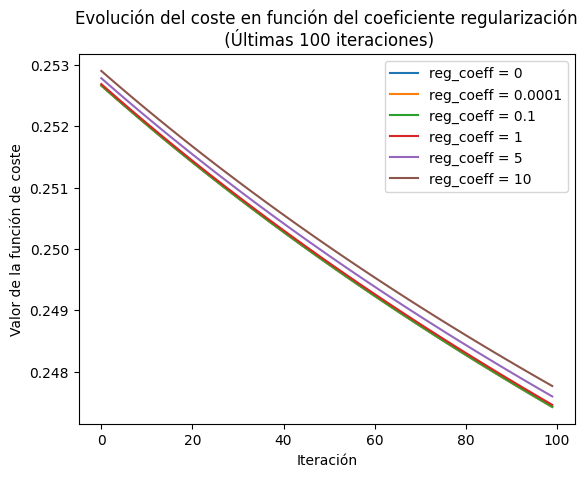

In [ ]:
colors = ['blue','orange','green','red','black','purple']
for i in range(len(loss_list)):
  plt.plot(loss_list[i][300:])
plt.legend(["reg_coeff = 0", "reg_coeff = 0.0001","reg_coeff = 0.1","reg_coeff = 1","reg_coeff = 5","reg_coeff = 10"], loc ="upper right")
plt.ylabel('Valor de la función de coste')
plt.xlabel('Iteración')
plt.title('Evolución del coste en función del coeficiente regularización\n (Últimas 100 iteraciones)')

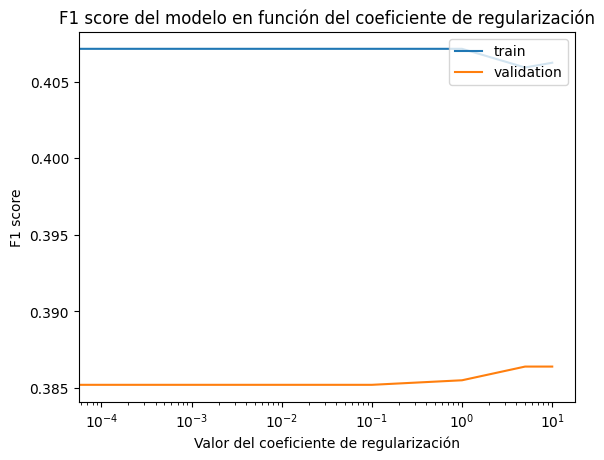

In [ ]:
plt.plot(regularization_params,f1_score_list)
plt.plot(regularization_params,val_f1score_list)
plt.xscale('log')
plt.ylabel('F1 score')
plt.xlabel('Valor del coeficiente de regularización')
plt.title('F1 score del modelo en función del coeficiente de regularización')
plt.legend(['train', 'validation'], loc='upper right')

En la gráfica se puede observar como el coeficiente de regularización no afecta demasiado al rendimiento en entrenamiento y en validación salvo para valores mayores que 0.1. Por esta razón vamos a elegir arbitrariamente 0.01.

<a name="metricas"></a>
## Métricas

Fijado el coeficiente de regularización, entrenamos el modelo con distintas proporciones del conjunto de entrenamiento para observar la curva de aprendizaje.

In [ ]:
_, alpha, umbral, pol_grad = best_hyperparams
reg = 0.01
tam_train = [10, 50, 100, 200, 300, 500,700, 1000, 1500, 3000, 5000, 10000, 15000, len(X_train)] 
loss_list = []
val_loss_list = []
f1score_list = []
val_f1score_list = []
#Probamos para distintos tamaños del conjunto de entrenamiento
for tam in tam_train:
  print(tam)
  model_X, w, b, num = build_model(X_train[:tam], pol_grad)
  num_w = num - 1
  loss_history, min_w, min_b, min_loss = descenso_gradiente_vec(model_X, y_train[:tam],num_w, w, b, reg,alpha,funcion,200)
  #Calculamos métricas para entrenamiento y validación
  loss = min_loss
  loss_list.append(loss)
  f1score = calcular_f1_score(model_X,y_train[:tam],min_w,min_b,umbral)
  f1score_list.append(f1score)
  model_X, _, _, _ = build_model(X_test, pol_grad)
  loss = calcula_coste_vec(model_X,y_valid,min_w,min_b,funcion,reg)
  val_loss_list.append(val_loss)
  val_f1score = calcular_f1_score(model_X,y_valid,min_w,min_b,umbral)
  val_f1score_list.append(val_f1score)

10
50
100
200
300
500
700
1000
1500
3000
5000
10000
15000
27828


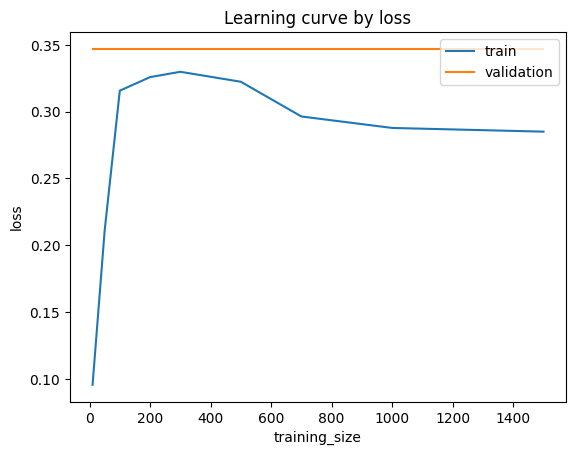

In [ ]:
  plt.plot(tam_train[:9],loss_list[:9])
  plt.plot(tam_train[:9],val_loss_list[:9])
  plt.title('Learning curve by loss')
  plt.ylabel('loss')
  plt.xlabel('training_size')
  plt.legend(['train', 'validation'], loc='upper right')
  plt.show()

La curva de aprendizaje con respecto a la función loss sigue una tendencia usual. Para pocos datos de entrenamiento el loss es muy bajo ya que predice muy bien los pocos datos de los que dispone. Según aumenta el tamaño del conjunto de entrenamiento, el modelo generaliza más y por tanto el loss en entrenamiento empeora. En este caso el loss en validación se mantiene constante para cualquier tamaño de entrenamiento.

In [ ]:
_, alpha, umbral, pol_grad = best_hyperparams
reg = 0.01
model_X, w, b, num = build_model(X_train, pol_grad)
num_w = num - 1
loss_history, min_w, min_b, min_loss = descenso_gradiente_vec(model_X, y_train,num_w, w, b, reg,alpha,funcion,300)

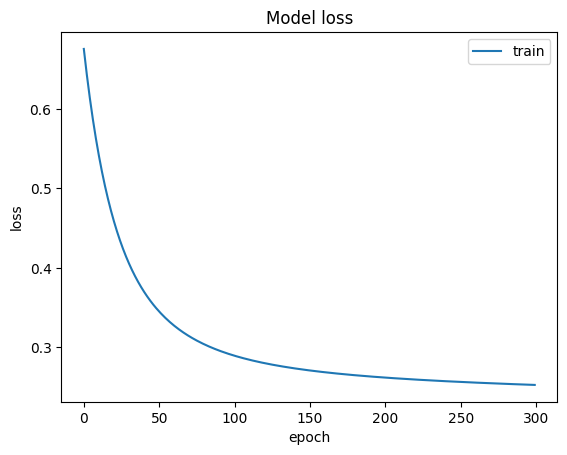

In [ ]:
plt.plot(loss_history)
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper right')
plt.show()

Como vemos en la gráfica de la historia del loss, a partir de 200 epochs el loss converge. Por esto hemos decidido calcular un epoch a partir del cual si no mejora el modelo dejar de entrenar, similar a la función de early_stopping.

In [ ]:
delta = 0.0001

anterior = loss_history[0]
epochs = 0
for i in range(1,len(loss_history)):
  if anterior - loss_history[i] < delta:
    epochs = i
    break
  anterior = loss_history[i]

epochs

235

<a name="eval"></a>
## Evaluación del modelo

Después de realizar todo lo anterior entrenamos el modelo en el conjunto de entrenamiento y validación para valorar su rendimiento con el conjunto de test y observar así su comportamiento.

In [ ]:
X_trainval = np.concatenate((X_train, X_valid), axis=0)
y_trainval = np.concatenate((y_train, y_valid), axis=0)

In [ ]:
tic = time.time()
model_X, w, b, num = build_model(X_trainval, pol_grad)
num_w = num - 1
loss_history, min_w, min_b, min_loss = descenso_gradiente_vec(model_X, y_trainval,num_w, w, b, reg,alpha,funcion,epochs)
toc = time.time()
t = toc - tic

best_hyperparams = reg, alpha, umbral, pol_grad
print("Best Hyperparameters:", best_hyperparams, ('regularization_coefficient', 'learning_rate', 'umbral', 'polynomial_degree'))
print(f'Tiempo de ejecución del entrenamiento {t}')

loss = min_loss
accuracy = calcular_accuracy(model_X,y_trainval,min_w,min_b,umbral)
precision = calcular_precision(model_X,y_trainval,min_w,min_b,umbral)
recall = calcular_recall(model_X,y_trainval,min_w,min_b,umbral)
false_negatives = calcular_false_negatives(model_X,y_trainval,min_w,min_b,umbral)
f1score = calcular_f1_score(model_X,y_trainval,min_w,min_b,umbral)

print(f'TRAIN \nLoss: {loss} \nAccuracy: {accuracy} \nPrecision: {precision}\nRecall: {recall}\nFalse negatives: {false_negatives}\nF1Score: {f1score}')

model_X, _, _, _ = build_model(X_test, pol_grad)
loss = calcula_coste_vec(model_X,y_test,min_w,min_b,funcion,reg)
accuracy = calcular_accuracy(model_X,y_test,min_w,min_b,umbral)
precision = calcular_precision(model_X,y_test,min_w,min_b,umbral)
recall = calcular_recall(model_X,y_test,min_w,min_b,umbral)
false_negatives = calcular_false_negatives(model_X,y_test,min_w,min_b,umbral)
f1score = calcular_f1_score(model_X,y_test,min_w,min_b,umbral)


print(f'TEST \nLoss: {loss} \nAccuracy: {accuracy} \nPrecision: {precision}\nRecall: {recall}\nFalse negatives: {false_negatives}\nF1Score: {f1score}')

Best Hyperparameters: (0.01, 0.1, 0.2, 1) ('regularization_coefficient', 'learning_rate', 'umbral', 'polynomial_degree')
Tiempo de ejecución del entrenamiento 27.737430095672607
TRAIN 
Loss: 0.25791013548386776 
Accuracy: 0.914133247089238 
Precision: 0.5188328912464091
Recall: 0.30027632790902664
False negatives: 2279
F1Score: 0.3803967327886502
TEST 
Loss: 0.2555139095912371 
Accuracy: 0.9139715394565637 
Precision: 0.5162601626005767
Recall: 0.3120393120389287
False negatives: 560
F1Score: 0.3889739663087458


A la vista de los resultados se ve que es el peor modelo de los tres salvo en precision y accuracy. Las métricas que nos interesann son tanto el F1 score como los falsos negativos para los cuales da el peor rendimiento de los tres.

In [ ]:
model_X, _, _, _ = build_model(X_test, pol_grad)
y_pred = sigmoid(funcion(model_X,min_w,min_b))
y_pred = y_pred > umbral

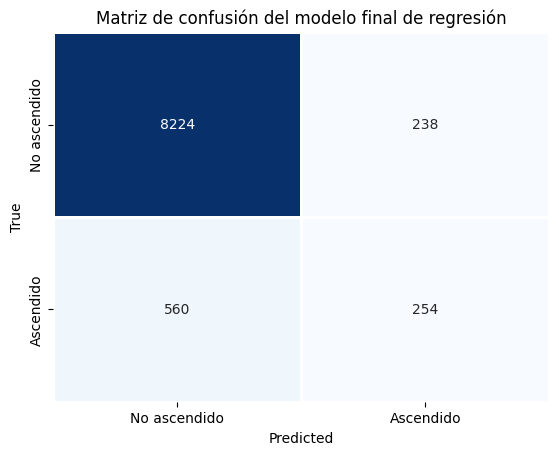

In [ ]:
def plot_confusion_matrix(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred)
    ax = sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", cbar=False, annot_kws={'fontsize' : 10 }, linewidths=1, linecolor='white')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)
    ax.set_title('Matriz de confusión del modelo final de regresión')
    plt.show()

plot_confusion_matrix(y_test, y_pred, ['No ascendido','Ascendido'])
  

Como se puede observar en la matriz de confusión del modelo, la razón por la que tiene un accuracy y una precisión altas es porque predice bien los casos negativos (no ascendidos) que son la mayoría. Esto es debido a que al no tener una forma de poder darles pesos a las diferentes clases el modelo ha aprendido a predecir bien la clase mayoritaria que en este caso es la de 'No ascendidos' o 0. Esto se ha intentado solucionar probando valores de umbral bajos a partir de los cuales predecir la clase como 1 aunque no ha sido suficiente (el modelo utiliza 0.2 mientras que en un modelo con un reparto equitativo se suele utilizar el 0.5). Por otro lado el modelo no predice bien la clase minoritaria (clase 1 o 'Ascendidos') lo que se refleja en el número de verdaderos positivos (254/814), el elevado número de falsos negativos en comparación con otros modelos, y en consecuencia el bajo F1 Score.

<a name="conclusion"></a>
# Conclusión

Los parámetros elegidos para la regresión final dan lugar al peor modelo de los tres que se van a probar. El número de false negatives es de 560 prediciendo bien 31% (recall) de los casos ascendidos. Predice como ascendidos al 2.8% de los que no deberían ser ascendidos por lo que en este sentido el modelo funciona bien, pero como hemos explicado antes, no es la métrica que más nos interesa. En total recomienda para ascenso un total de 492 empleados, siendo correctas el 51.6% (precision) de las recomendaciones, es decir, aproximadamente la mitad.

El modelo en general resulta poco útil aunque tiene algún punto fuerte con respecto a los otros. Por un lado nunca asciende a empleados que no debería ascender, y por otro lado, más de la mitad de las recomendaciones que hace son aciertos, números que no podemos ver en todos los modelos.

Aunque tenga algunas ventajas con respecto a los otros modelos, si nos fijamos en nuestros objetivos iniciales, no son estos los aspectos que queríamos que funcionaran mejor.

Una forma de mejorar el modelo es la elección de un grado polinomial (en la transformación) más alto. Hemos observado que el mejor modelo de los probado tenía grado 2 sin embargo se ha utilizado el de grado 1 (el segundo mejor) debido al tiempo de entrenamiento. 

<a name="bib"></a>
# Bibliografía

- Apuntes de evaluación: https://cvmdp.ucm.es/moodle/mod/resource/view.php?id=2387418
- Apuntes de regresión: https://cvmdp.ucm.es/moodle/mod/resource/view.php?id=2342008
- Práctica de regresión: https://cvmdp.ucm.es/moodle/mod/resource/view.php?id=2360954